In [1]:
import os
import sys
import warnings
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th
import pickle
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from scripts.utils import (
    load_scenario_data,
    verify_training_folders,
    create_results_directory,
    get_model_version,
    format_days,
    calculate_training_days,
    initialize_device,
    check_device_capabilities,
    get_device_info,
)
from scripts.visualizations import *
from src.config import *
from sb3_contrib import MaskablePPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from src.environment import AircraftDisruptionEnv
from sb3_contrib.common.maskable.utils import get_action_masks

device = initialize_device()

LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000 * 2
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 5000
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 512, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4
N_STEPS = 100
TRAINING_FOLDERS_PATH = "../data/Training/3ac-10/"

num_days_trained_on = 10
formatted_days = format_days(num_days_trained_on)
model_name = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
MODEL_SAVE_PATH = '../trained_models/ppo/'
MODEL_SAVE_NAME_MYOPIC = f'{model_name}-{formatted_days}-{get_model_version(model_name, "myopic", "ppo")}.zip'
MODEL_SAVE_NAME_PROACTIVE = f'{model_name}-{formatted_days}-{get_model_version(model_name, "proactive", "ppo")}.zip'
print(f"Models will be saved to:\n   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}\n   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")

results_dir = create_results_directory(append_to_name='ppo')
print(f"Results directory created at: {results_dir}")

# Store episode-level rewards
episode_rewards_myopic = []
episode_rewards_proactive = []

def my_get_action_masks(env):
    mask = env.get_action_mask()
    mask = np.array(mask, dtype=np.uint8)
    return mask

def train_ppo_agent(env_type):
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    class ScenarioEnvWrapper(gym.Env):
        
        def __init__(self, scenario_folders, env_type):
            super(ScenarioEnvWrapper, self).__init__()
            self.scenario_folders = scenario_folders
            self.env_type = env_type
            self.current_scenario_idx = -1

            # Track meta-episode rewards
            self.episode_scenario_rewards = []  # rewards from each scenario in the current episode
            self.episode_count = 0

            self.load_next_scenario()
            self.observation_space = self.env.observation_space
            self.action_space = self.env.action_space
            self.episode_reward = 0  # reward within a single scenario

        def load_next_scenario(self):
            self.current_scenario_idx = (self.current_scenario_idx + 1) % len(self.scenario_folders)
            scenario_folder = self.scenario_folders[self.current_scenario_idx]
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            self.env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=self.env_type
            )

        def reset(self, seed=None, options=None):
            # If this is not the first reset, we finished one scenario.
            # Add the scenario's accumulated reward to the episode scenario rewards.
            if self.episode_reward != 0:
                self.episode_scenario_rewards.append(self.episode_reward)
                self.episode_reward = 0

            # If we have completed a full cycle of scenarios, that means one meta-episode is done.
            if len(self.episode_scenario_rewards) == len(self.scenario_folders):
                total_episode_reward = sum(self.episode_scenario_rewards)
                if self.env_type == "myopic":
                    episode_rewards_myopic.append(total_episode_reward)
                else:
                    episode_rewards_proactive.append(total_episode_reward)

                # Reset for next meta-episode
                self.episode_scenario_rewards = []
                self.episode_count += 1

            self.load_next_scenario()
            obs, info = self.env.reset()
            return obs, info


        def step(self, action):
            obs, reward, done, truncated, info = self.env.step(action)
            self.episode_reward += reward  # accumulate reward for current scenario
            return obs, reward, done, truncated, info

        def render(self, mode='human'):
            return self.env.render(mode=mode)

        def close(self):
            return self.env.close()

        def get_action_mask(self):
            return self.env.get_action_mask()

    env = ScenarioEnvWrapper(scenario_folders, env_type)
    env = ActionMasker(env, my_get_action_masks)
    env = DummyVecEnv([lambda: env])

    model = MaskablePPO(
        'MultiInputPolicy',
        env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        verbose=1,
        tensorboard_log=f"./ppo_aircraft_tensorboard_{env_type}/",
        device=device,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        n_steps=N_STEPS,
    )

    logger = configure()
    model.set_logger(logger)

    def log_rewards(_locals, _globals):
        # Here you can log episode metrics if needed.
        # The actual per-episode logging is done after training by
        # checking the global lists.
        return True

    # Run the training loop for a fixed number of timesteps
    model.learn(total_timesteps=MAX_TIMESTEPS, use_masking=True, callback=log_rewards)

    if env_type == "myopic":
        model.save(f"{MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}")
    else:
        model.save(f"{MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")

    return [], 0  # We return empty arrays here since we log after training

start_time = datetime.now()
results_myopic = train_ppo_agent('myopic')
results_proactive = train_ppo_agent('proactive')
rewards_myopic, total_timesteps_myopic = results_myopic
rewards_proactive, total_timesteps_proactive = results_proactive

# Now, rewards_myopic and rewards_proactive are empty because we changed the logic.
# # The actual results are in episode_rewards_myopic and episode_rewards_proactive.

# myopic_rewards_file = os.path.join(results_dir, "episode_rewards_myopic.pkl")
# with open(myopic_rewards_file, "wb") as file:
#     pickle.dump(episode_rewards_myopic, file)
# print(f"Myopic episode-level rewards saved to {myopic_rewards_file}")

# proactive_rewards_file = os.path.join(results_dir, "episode_rewards_proactive.pkl")
# with open(proactive_rewards_file, "wb") as file:
#     pickle.dump(episode_rewards_proactive, file)
# print(f"Proactive episode-level rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()
print(f"Total training time: {runtime} seconds")

print("Myopic per-episode rewards:", episode_rewards_myopic)
print("Proactive per-episode rewards:", episode_rewards_proactive)


Using device: mps
Getting model version for 3ac-10
Getting model version for 3ac-10
Models will be saved to:
   ../trained_models/ppo/myopic_3ac-10-10-1.zip
   ../trained_models/ppo/proactive_3ac-10-10-1.zip
Results directory created at: ../results/ppo/20241206-03-52
Using mps device
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-06-03-52-50-538116
----------------------------
| time/              |     |
|    fps             | 114 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 100 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 74           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 200          |
| train/                  |              |
|    approx_kl            | 4.255875e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2   

KeyboardInterrupt: 

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_53860/356212042.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


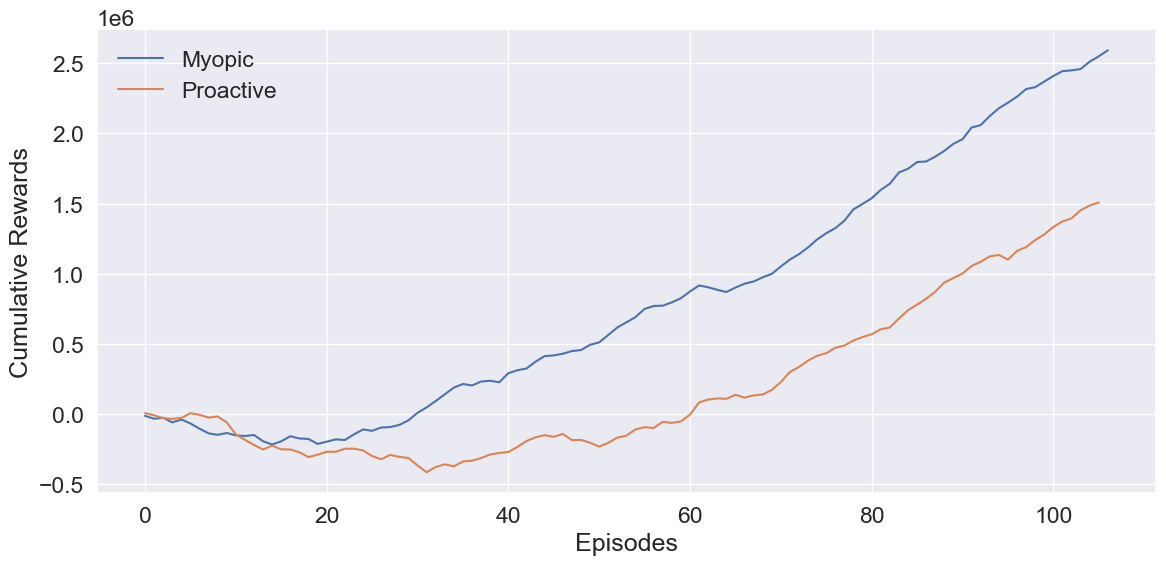

Reward comparison plot saved to ../results/ppo/20241206-03-38/reward_comparison_plot.png


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_rewards(episode_rewards_myopic, episode_rewards_proactive, results_dir, smooth=1):
    """
    Plot cumulative episode rewards for the myopic and proactive environments with optional smoothing.
    
    Args:
        episode_rewards_myopic (list): Per-episode total rewards for the myopic environment.
        episode_rewards_proactive (list): Per-episode total rewards for the proactive environment.
        results_dir (str): Directory to save the resulting plot.
        smooth (int): Smoothing factor (rolling average window size) for cumulative rewards.
    """
    data = []

    # Process myopic rewards
    if len(episode_rewards_myopic) > 0:
        cumulative_myopic = np.cumsum(episode_rewards_myopic)
        if smooth > 1:
            cumulative_myopic = np.convolve(cumulative_myopic, np.ones(smooth)/smooth, mode='valid')
        data.append(pd.DataFrame({
            "Episodes": range(len(cumulative_myopic)),
            "Cumulative Rewards": cumulative_myopic,
            "Environment": "Myopic"
        }))

    # Process proactive rewards
    if len(episode_rewards_proactive) > 0:
        cumulative_proactive = np.cumsum(episode_rewards_proactive)
        if smooth > 1:
            cumulative_proactive = np.convolve(cumulative_proactive, np.ones(smooth)/smooth, mode='valid')
        data.append(pd.DataFrame({
            "Episodes": range(len(cumulative_proactive)),
            "Cumulative Rewards": cumulative_proactive,
            "Environment": "Proactive"
        }))

    if not data:
        print("No data available to plot.")
        return

    # Combine into a single DataFrame
    plot_data = pd.concat(data, ignore_index=True)

    # Create the plot
    sns.set(style="darkgrid", font_scale=1.5)
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=plot_data,
        x="Episodes",
        y="Cumulative Rewards",
        hue="Environment",
        ci='sd'
    )
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Rewards")
    plt.legend(frameon=False)
    plt.tight_layout()

    # Save and show the plot
    plot_file = os.path.join(results_dir, "reward_comparison_plot.png")
    plt.savefig(plot_file)
    plt.show()
    print(f"Reward comparison plot saved to {plot_file}")

# Example usage:
plot_rewards(episode_rewards_myopic, episode_rewards_proactive, results_dir)


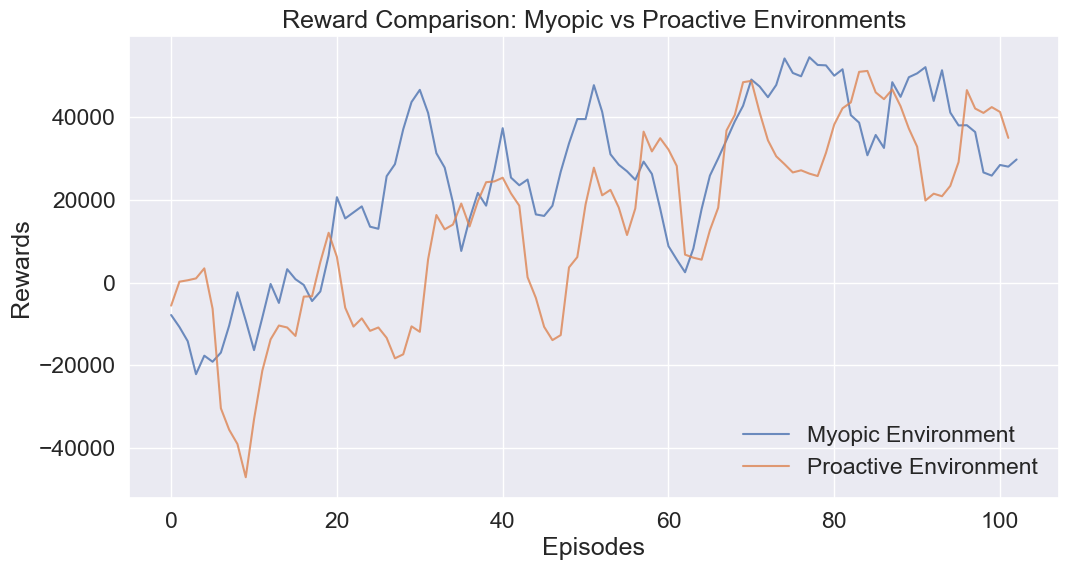

Reward comparison plot saved to ../results/ppo/20241206-03-38/reward_comparison_plot.png


In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_rewards(episode_rewards_myopic, episode_rewards_proactive, results_dir, smooth=5):
    """
    Plot raw episode rewards for myopic and proactive environments for comparison.
    
    Args:
        episode_rewards_myopic (list): Per-episode total rewards for the myopic environment.
        episode_rewards_proactive (list): Per-episode total rewards for the proactive environment.
        results_dir (str): Directory to save the resulting plot.
        smooth (int): Window size for smoothing the rewards. Default is 1 (no smoothing).
    """
    plt.figure(figsize=(12, 6))
    
    if len(episode_rewards_myopic) > 0:
        myopic_rewards = episode_rewards_myopic
        if smooth > 1:
            myopic_rewards = np.convolve(myopic_rewards, np.ones(smooth)/smooth, mode='valid')
        plt.plot(myopic_rewards, label="Myopic Environment", alpha=0.8)
        
    if len(episode_rewards_proactive) > 0:
        proactive_rewards = episode_rewards_proactive
        if smooth > 1:
            proactive_rewards = np.convolve(proactive_rewards, np.ones(smooth)/smooth, mode='valid')
        plt.plot(proactive_rewards, label="Proactive Environment", alpha=0.8)
    
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Reward Comparison: Myopic vs Proactive Environments")
    plt.legend(frameon=False)
    plt.grid(True)
    
    plot_file = os.path.join(results_dir, "reward_comparison_plot.png")
    plt.savefig(plot_file)
    plt.show()
    print(f"Reward comparison plot saved to {plot_file}")

# Example usage:
plot_rewards(episode_rewards_myopic, episode_rewards_proactive, results_dir)
